In [1]:
import pandas as pd
import pickle,os, copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy

import re

import margin_flatness as mf
import margin_flatness.postprocessing as mf_post


%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

In [3]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"
exp = "CE_F1"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [4]:
stats_df = mf_post.stats_plotting.get_end_stats(experiment_folder, step=-1)


In [5]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

,Loss Test Mean,Loss Train Mean,Acc Train Mean,Acc Test Mean,Acc Gap Mean,batch_train_size,learning_rate,seed,weight_decay
1605777199.6255481,0.055523,0.001748,0.999867,0.9847,-0.015167,32,0.01,0,0.0005
1605839859.6129062,0.056597,0.001824,0.999867,0.9845,-0.015367,32,0.01,5,0.0005
1605724651.0897503,0.055077,0.007480,0.998217,0.9842,-0.014017,32,0.1,0,0.0001
1605728268.265154,0.051580,0.006640,0.998417,0.9840,-0.014417,32,0.1,10,0.0001
1605754885.6487322,0.061488,0.001164,0.999983,0.9838,-0.016183,256,0.05,0,0.0005
...,...,...,...,...,...,...,...,...,...
1605720879.3374493,0.083767,0.028003,0.991567,0.9748,-0.016767,32,0.1,0,0
1605723063.3285263,0.093201,0.000512,1.000000,0.9745,-0.025500,1024,0.01,5,0
1605723451.315186,0.091434,0.027657,0.991200,0.9727,-0.018500,32,0.1,10,0
1605795553.9344513,0.090816,0.037907,0.989067,0.9721,-0.016967,32,0.1,5,0.0005


# Plot a histogram for kendall and isotonic R^2 value. 

In [6]:
# Plot histogram Kendall 

In [20]:
all_point_traces, _ = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
all_point_output_margins, _ = mf.save_load.load_cached_data(experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


In [79]:
exp_ids = stats_df.index

kendall_coeffs = {}
num_nets = 1
for exp_id in exp_ids:
    for nn_idx in range(num_nets):
        x_data = all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = all_point_output_margins[exp_id]["{}".format(nn_idx)]
        kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation
    


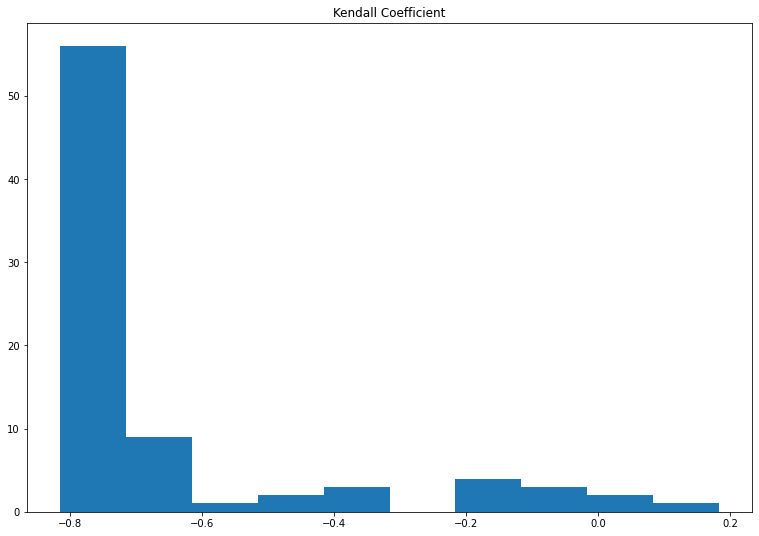

In [80]:
plt.hist(list(kendall_coeffs.values()))
plt.title("Kendall Coefficient")
plt.show()

In [23]:
# Plot R2 of isotopic

In [81]:
exp_ids = stats_df.index

r2_coeffs = {}
num_nets = 1
for exp_id in exp_ids:
    for nn_idx in range(num_nets):
        x_data = all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = all_point_output_margins[exp_id]["{}".format(nn_idx)]
        r2_coeffs[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing=False)
    


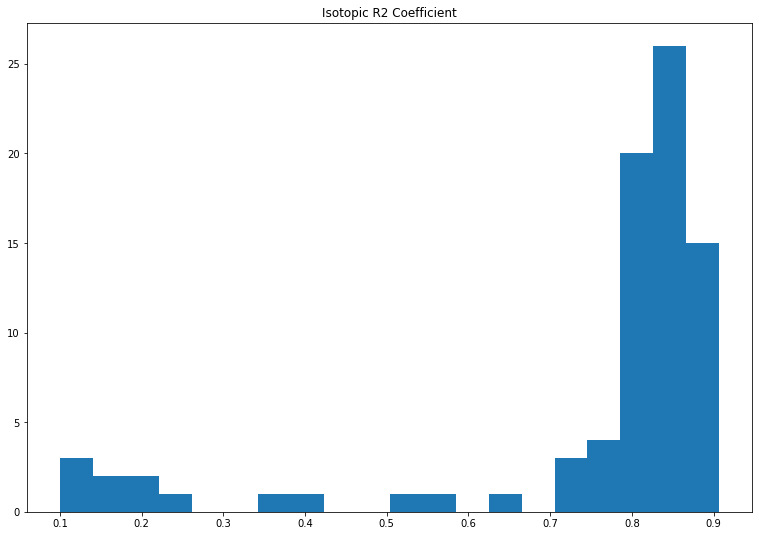

In [82]:
plt.hist(list(r2_coeffs.values()), bins=20)
plt.title("Isotopic R2 Coefficient")
plt.show()

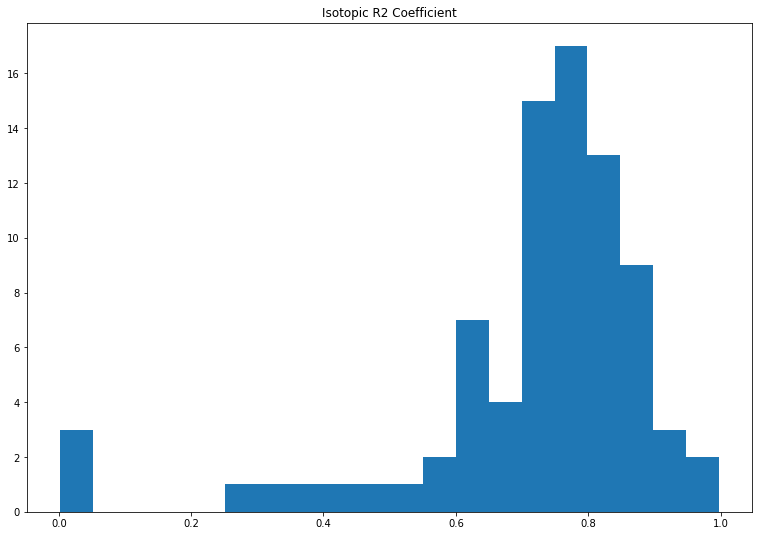

In [59]:
plt.hist(list(r2_coeffs_auto.values()), bins=20)
plt.title("Isotopic R2 Coefficient")
plt.show()

(array([[ 0.,  0.,  0.,  3.,  1.,  2.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
          0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  3.,  2., 10., 18., 21.,
         12.,  2.,  0.,  0.],
        [ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
          0.,  1.,  0.,  3.,  0.,  6.,  2.,  3., 10., 11., 11., 10.,  7.,
          5.,  2.,  1.,  2.]]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 2 BarContainer objects>)

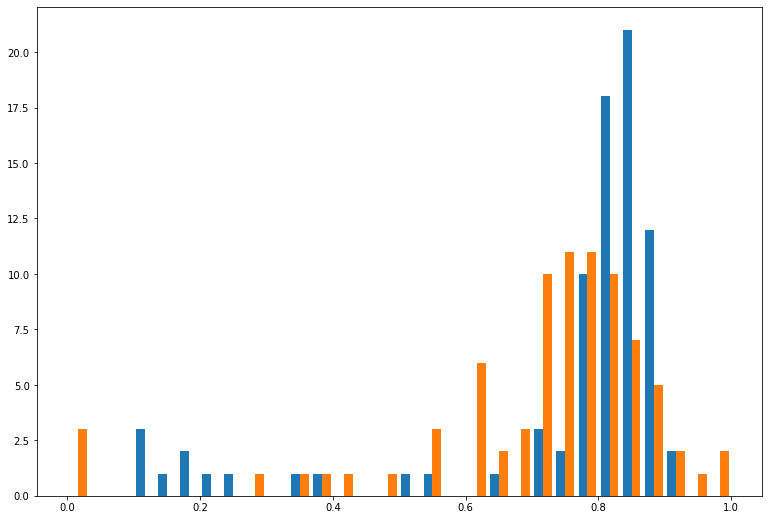

In [83]:
plt.hist([list(r2_coeffs.values()), list(r2_coeffs_auto.values())], bins=30, range=(0, 1), stacked=False)

# plt.hist(list(r2_coeffs_auto.values()), bins=30, range=(0, 1), density=True)


# Plot every point on one plot

In [91]:
exp_ids = stats_df.index

all_x_data = []
all_y_data = []
num_nets = 1
for exp_id in exp_ids:
    for nn_idx in range(num_nets):
        x_data = all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = all_point_output_margins[exp_id]["{}".format(nn_idx)]
        all_x_data.append(np.mean(x_data))
        all_y_data.append(np.min(y_data))


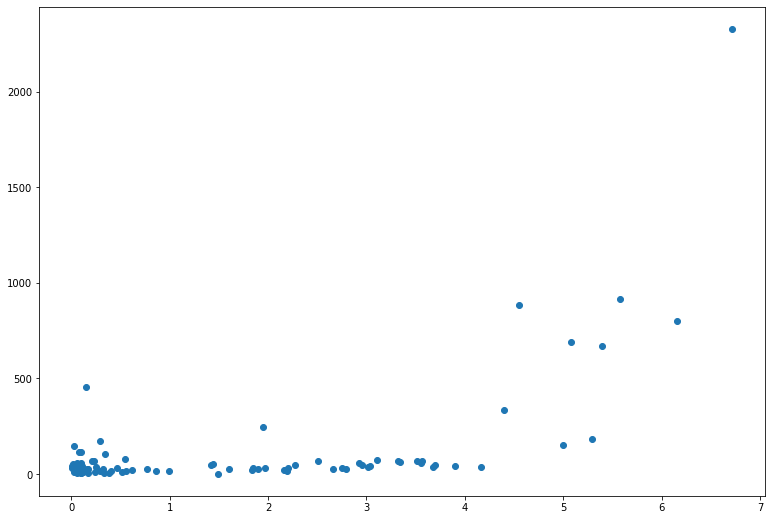

In [92]:
plt.scatter(all_y_data, all_x_data)

In [95]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score
mf_post.correlation.get_isotonic_r_squared(all_y_data, all_x_data, remove_outliers=False, increasing=True)

0.912455696794305

# Plot Correlations

In [ ]:
# all_steps = mf.save_load.get_exp_steps(experiment_folder)
# all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
# all_steps = sorted(list(set(all_steps)))

# Plot trace vs margins
# X_axis_name = "Output Margins"
X_axis_name = "Output Margins"
Y_axis_name = "Empirical Trace"


plot_name = "C_IC"
X_axis_bounds = None #[0, 1.001]
Y_axis_bounds = None #[0, 200]

should_save = False


filter_seperate = ["batch_train_size", "learning_rate", "weight_decay", "seed"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True



In [ ]:
if should_save:
    save_time_path = os.path.join(experiment_folder, "time_corr")
    if not os.path.isdir(save_time_path):
        os.mkdir(save_time_path)
else:
    save_time_path = None

for step in [-1]:
#     acc, _ = load_cached_data(experiment_folder, "acc", step=step)
    
    curr_point_traces, meta = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=step)
    if X_axis_name == "Output Margins":
        corr_candidate_filter = mf_post.postprocess_experiment.get_exp_margins(experiment_folder, softmax_outputs=False, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    
    if X_axis_name == "Jacobian":
        corr_candidate_filter = mf_post.postprocess_experiment.get_exp_inp_out_jacobian(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    
    curr_plot_name = "{}_step_{}".format(plot_name, step)
    
    data_func = mf_post.stats_plotting.margin_trace_correct_incorrect_plot(corr_candidate_filter, curr_point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)
    
    mf_post.stats_plotting.hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                      curr_plot_name, filter_seperate, filter_not_seperate,
                 save_time_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)

 


In [ ]:
# root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
# data_name = "MNIST"
# exp = "Keskar_F1"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)


# X_data_filter_f = lambda step: get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

X_data_filter_f = lambda step: get_exp_margins(experiment_folder, get_upperbound=True, softmax_outputs=True, step=step, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False) # get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

Y_data_f = lambda step:  load_cached_data(experiment_folder, "point_traces", step=step)[0]
use_correct_filter = True
c = get_corr_array(experiment_folder, X_data_filter_f, Y_data_f, use_correct_filter)


In [ ]:
for exp_id in c:
    if exp_id != "1605478459.1644921":
        continue
        
    a = c[exp_id]["0"]

    plots = []
    plots_names = []
    X_axis_name = "training step"
    Y_axis_name = "r value"

    save_location = None # os.path.join(experiment_folder, "time_r_margins_{}".format(stats_df.loc[exp_id]["batch_train_size"]))


    plots.append(plt.plot(list(a["correct_r_value"].keys()), list(a["correct_r_value"].values()), label="Correctly Predicted", color=COLORS[CORRECT_COLOR_IDX]))
    plots.append(plt.plot(list(a["incorrect_r_value"].keys()), list(a["incorrect_r_value"].values()), label="Incorrectly Predicted",  color=COLORS[INCORRECT_COLOR_IDX]))
#     plots_names = ["Correctly Predicted", "Incorrectly Predicted"] 

    
    costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



In [ ]:
plots = []
plots_names = []
X_axis_name = "training step"
Y_axis_name = "training accuracy"

save_location = os.path.join(experiment_folder, "time_acc")


plots.append(plt.plot(list(a["acc"].keys()), list(a["acc"].values())))

costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



In [ ]:
h_arr = []
m_arr = []
for step in np.linspace(0, 10000, 21):
    print(step)
    curr_point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=int(step)+1)
    h_arr.append(curr_point_traces)
#         linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=step+1, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    linear_loss_trace_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=int(step) + 1, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
#     h_arr.append(curr_point_traces)
    m_arr.append(linear_loss_trace_filters)
    




In [ ]:
h_res = [[], []]
for t in range(len(m_arr)):
    for i, exp_id in enumerate(h_arr[t]):
        h = h_arr[t][exp_id]['0']
#         h_res[i].append(np.mean(h))
        h_res[i].append(scipy.stats.moment(h, moment=3))

In [ ]:
plt.plot(h_res[0][15:])
plt.plot(h_res[1][15:])


In [ ]:
plt.plot(h_res[0])
plt.plot(h_res[1])


In [ ]:
res = [[], []]
for t in range(len(m_arr)):
    for i, exp_id in enumerate(m_arr[t]):
        m, f = m_arr[t][exp_id]['0']
#         res[i].append(np.mean(m[f]))
        res[i].append(scipy.stats.moment(m[f], moment=3))

In [ ]:
res

In [ ]:
plt.plot(res[0])
plt.plot(res[1])


In [ ]:
plt.plot(res[0])
plt.plot(res[1])


In [ ]:
import margin_flatness.nets as mf_nets 
from torch.utils.data import DataLoader


In [ ]:
# exp_name = "1605702831.5614505"
exp_name = "1605720879.3374493"
models = mf.save_load.get_models(os.path.join(experiment_folder, "models", exp_name), step=-1, device=None)

cfgs = mf.save_load.load_configs(experiment_folder)
criterion = mf.training_utils.get_criterion(cfgs.loc[exp_name])


In [ ]:


train_data, test_data = mf_post.postprocess_experiment.get_data_for_experiment(experiment_folder)

num_datapoints = 1000
seed = 0
N = 100
data= mf.data_getters.get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)

In [ ]:
curr_point_traces, meta = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=-1)


In [ ]:
s = mf_post.sharpness_measures.sample_average_flatness_pointwise(models, data, criterion, N, 0.0001, seed=seed)

In [ ]:
# ps = mf_post.sharpness_measures.get_point_traces(models, data, criterion, device=None, seed=seed)

In [ ]:
plt.scatter(curr_point_traces[exp_name]['0'], s['0'])

In [ ]:
r = mf_post.robustness.sample_average_robustness_pointwise(models, data, criterion, N, 1, seed=seed)

In [ ]:
plt.scatter(r['0'], s['0'])